## Figure 2.B
### Comparison of RNA002 U-to-C mismatch percentage and Dorado Ψ reported occupancy for reads with valid coverage of 20.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import sys
import time
import pickle
import os.path as osp
import tqdm
import pysam
import seaborn as sns
from matplotlib_venn import venn3, venn2
from sklearn.metrics import mean_squared_error

### Intersection of U-to-C with modkit for both rna2 and rna4

In [9]:
# intersecting modkit and pysamstats

modkit_df = pd.read_csv('08_07_24_R9RNA_GM12878_mRNA_RT_sup_8mods_polyA_sorted_filtered.chr12-112000000-114000000_modkit_ivt_correct.tsv', sep='\t')

modkit_df.columns = [
    "chrom", "start_position", "end_position", "modified_base_code", "score", 
    "strand", "start_position_compat", "end_position_compat", "color", 
    "Nvalid_cov", "fraction_modified", "Nmod", "Ncanonical", "Nother_mod", 
    "Ndelete", "Nfail", "Ndiff", "Nnocall", "ivt_correct"
]
## fitering for >= 20 reads coverage
modkit_df = modkit_df[modkit_df["score"] >= 20]

## filtering for Psi mod code
modkit_df = modkit_df[modkit_df['modified_base_code'].astype(str) == "17802"]

pysamstats_df = pd.read_csv('RNA002_table_T2C_A2G.csv', sep="\t") 

# intersection based on the 'end_position' in modkit and 'pos' in pysamstats
intersection_df = pd.merge(modkit_df, pysamstats_df, left_on=['chrom','end_position'], right_on=['chrom','pos'])

intersection_df.to_csv('./modkit_pysamstats_RNA2_C_G.csv', sep=',', index=False)

print(intersection_df.head())

len(intersection_df)

   chrom  start_position  end_position modified_base_code  score strand  \
0  chr12       111933894     111933895              17802     32      -   
1  chr12       111933911     111933912              17802     34      -   
2  chr12       111933918     111933919              17802     31      -   
3  chr12       111933926     111933927              17802     35      -   
4  chr12       111933947     111933948              17802     31      -   

   start_position_compat  end_position_compat    color  Nvalid_cov  ...  \
0              111933894            111933895  255,0,0          32  ...   
1              111933911            111933912  255,0,0          34  ...   
2              111933918            111933919  255,0,0          31  ...   
3              111933926            111933927  255,0,0          35  ...   
4              111933947            111933948  255,0,0          31  ...   

         pos  ref   A  C  G  T  A_perc  C_perc  G_perc  T_perc  
0  111933895    A  20  0  0  0   

13893

## Dorado vs RNA002 U-to-C Mismatch Ratio

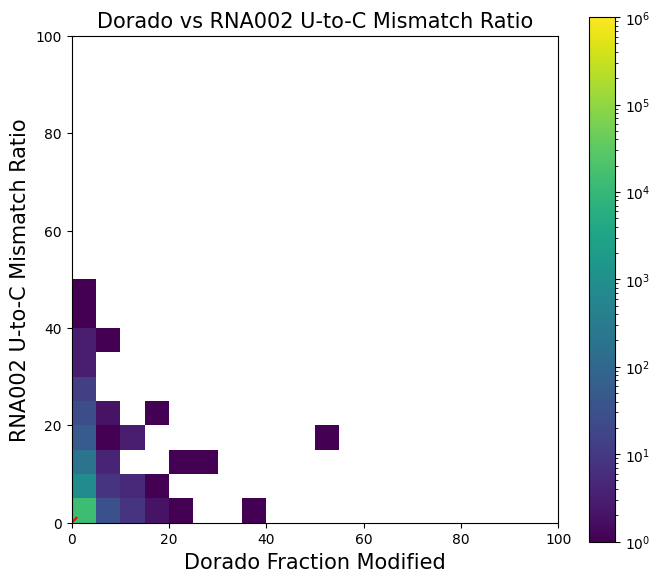

In [10]:
df = pd.read_csv('./modkit_pysamstats_RNA2_C_G.csv', sep=',')

df['mismatch_perc'] = np.where(df['ref'] == 'T', df['C_perc'], df['G_perc'])

df['mismatch_perc']*=100

fig, ax = plt.subplots()
fig.set_size_inches(7, 6)

cmap = mpl.cm.viridis
cmap.set_bad('white', 1.)

bandwidth_2d = 5
bins = np.arange(0, 100 + bandwidth_2d, bandwidth_2d)


hist = ax.hist2d(df['fraction_modified'], df['mismatch_perc'], 
                 bins=[bins, bins], norm=mpl.colors.LogNorm(vmin=1, vmax=1e6), cmap=cmap)

ax.plot((0.0, 1), (0.0, 1), color='red', alpha=1)
ax.set_xlabel('Dorado Fraction Modified', fontsize=15)
ax.set_ylabel('RNA002 U-to-C Mismatch Ratio', fontsize=15)
ax.set_title('Dorado vs RNA002 U-to-C Mismatch Ratio', fontsize=15)
fig.colorbar(hist[3], ax=ax)
ax.set_xlim(0.0, 100)
ax.set_ylim(0.0, 100)
ax.set_aspect('equal')
    
ax.tick_params(axis='both')
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    
fig.tight_layout()

plt.show()

### RMSE between Dorado fraction_modified and RNA002 U-to-C mismatch_perc:

In [11]:
df['mismatch_perc'] = np.where(df['ref'] == 'T', df['C_perc'], df['G_perc'])

df['fraction_modified'] /= 100

valid = df[(df['mismatch_perc'] > 0) & (df['fraction_modified'] > 0)]

mse = mean_squared_error(valid['fraction_modified'], valid['mismatch_perc'])
rmse = np.sqrt(mse)

print(f"RMSE between Dorado fraction_modified and RNA002 U-to-C mismatch_perc: {rmse:.4f}")

RMSE between Dorado fraction_modified and RNA002 U-to-C mismatch_perc: 0.0472
